In [1]:
from catboost import CatBoostClassifier
from matplotlib.pyplot import plot
from numpy import nan
from numpy import ndarray
from numpy import unique
from pandas import DataFrame
from pandas import read_csv
from pandas import Series
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
train_fname = '../input/spaceship-titanic/train.csv'
train_df = read_csv(filepath_or_buffer=train_fname)

In [3]:
def prepare(input_df: DataFrame) -> ndarray:
    result_df = input_df.drop(columns=['Transported', ], errors='ignore').copy(deep=True)
    result_df['Cabin_Deck'] = result_df['Cabin'].apply(func=lambda x: 'Unknown' if isinstance(x, float) else x.split('/')[0])
    result_df['Cabin_Side'] = result_df['Cabin'].apply(func=lambda x: 'Unknown' if isinstance(x, float) else x.split('/')[2])
    columns = ['CryoSleep', 'Destination', 'HomePlanet', 'Cabin_Deck', 'Cabin_Side', 'VIP']
    for column in columns:
        result_df[column] = LabelEncoder().fit_transform(y=result_df[column])
    result_df = result_df.drop(columns=['Cabin', 'Name', 'PassengerId',])
    return result_df

# get the labels
y = train_df['Transported'].values
x_df = prepare(input_df=train_df)
imputer = KNNImputer(missing_values=nan, n_neighbors=2, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False,)
x = imputer.fit_transform(x_df)

In [4]:
# split
random_state = 1
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state, stratify=y)

In [5]:
model = CatBoostClassifier(random_seed=random_state)

In [6]:
model.fit(X=x, y=y, eval_set=(x_test, y_test)) 

Learning rate set to 0.051161
0:	learn: 0.6670604	test: 0.6678208	best: 0.6678208 (0)	total: 59ms	remaining: 58.9s
1:	learn: 0.6442018	test: 0.6457072	best: 0.6457072 (1)	total: 62.9ms	remaining: 31.4s
2:	learn: 0.6233089	test: 0.6257463	best: 0.6257463 (2)	total: 66.1ms	remaining: 22s
3:	learn: 0.6065684	test: 0.6090373	best: 0.6090373 (3)	total: 69.2ms	remaining: 17.2s
4:	learn: 0.5928259	test: 0.5958407	best: 0.5958407 (4)	total: 72.2ms	remaining: 14.4s
5:	learn: 0.5770234	test: 0.5805903	best: 0.5805903 (5)	total: 75.2ms	remaining: 12.5s
6:	learn: 0.5658715	test: 0.5700119	best: 0.5700119 (6)	total: 78.1ms	remaining: 11.1s
7:	learn: 0.5566769	test: 0.5610028	best: 0.5610028 (7)	total: 81.2ms	remaining: 10.1s
8:	learn: 0.5472364	test: 0.5521054	best: 0.5521054 (8)	total: 84.2ms	remaining: 9.27s
9:	learn: 0.5403508	test: 0.5452713	best: 0.5452713 (9)	total: 87.2ms	remaining: 8.63s
10:	learn: 0.5313002	test: 0.5366774	best: 0.5366774 (10)	total: 90.1ms	remaining: 8.1s
11:	learn: 0.524

In [7]:
# plot(model.evals_result_['valid_0']['binary_logloss'])

<AxesSubplot:>

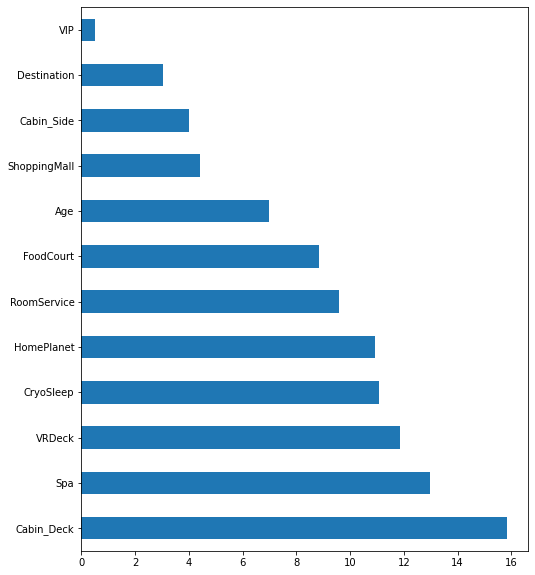

In [8]:
importance = Series(model.feature_importances_, index=x_df.columns)
importance.nlargest(30).plot(kind='barh', figsize=(8,10))

In [9]:
submission_df = read_csv('../input/spaceship-titanic/test.csv')
ids = submission_df['PassengerId'].values
submission_data_df = prepare(input_df=submission_df)
submission_data = imputer.transform(submission_data_df)
output_df = DataFrame({'PassengerId': ids, 'Transported': model.predict(submission_data) })
output_df.to_csv('submission.csv', index=False)

{'False': 1987, 'True': 2290}

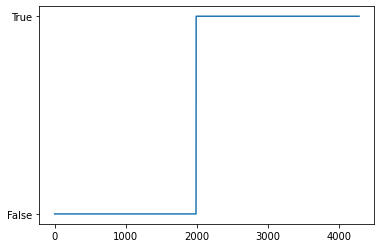

In [10]:
y_pred = model.predict(submission_data)
plot(sorted(y_pred.tolist()), )
values, counts = unique(y_pred, return_counts=True)
dict(zip(values, counts))